# Step 2: Solving the PDE with Neural Network

In this step, I have attempted to solve the PDE when s is not a constant and there is no analytical solution. I tried to solve the PDE for the case when s(x) goes from 1 to 2 in a tanh like fashion when x goes from -1 to 1. I have used a semi-supervised learning type approach where instead of labelled data I incorporate the original PDE (Equation 1) and Boundary conditions (Equation 2 and 3) in the loss function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from functools import wraps
from time import time
from math import*

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

def create_chunks(complete_list, chunk_size=None, num_chunks=None):

    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks


# Training data generators

In [2]:
def data_generator_pde(N):
    train_X = np.zeros((N,1))
    #train_X = np.zeros(N)
    y = np.linspace(-1,1,N)
    for i in range(N):
        train_X[i,0]=y[i]   
    return train_X,train_X

In [3]:
def data_generator(N,s):
    train_X = np.zeros((N,3))
    train_y = np.zeros((N))
    y = np.linspace(-1,1,N)

    for i in range(N):
        train_X[i,0] = s#0*np.random.rand() + 0.01 #s
        train_X[i,1] = y[i]
        train_X[i,2] = 0*2*np.random.rand() - 0*1.0 #x'
        train_y[i] = np.exp(-train_X[i,0]*abs(train_X[i,1]-train_X[i,2]))/(2*train_X[i,0])
        
    return train_y  



# Optimized architecture of the neural network.

In [4]:
from torch import nn
import torch
        

class ann(nn.Module):
    def __init__(self):
        super(ann, self).__init__()
        a = 200
        inp = 1
        self.Linear = nn.ModuleList([nn.Linear(inp,a),nn.Linear(a,a)
                                     ,nn.Linear(a,a),nn.Linear(a,a)
                                     ,nn.Linear(a,100),nn.Linear(100,1)])
        self.activation = nn.ModuleList([nn.Tanh()])
    def forward(self, x):
        for i in range(len(self.Linear)-1):
                x = self.activation[0](self.Linear[i](x))
        x = self.Linear[-1](x)  
        return x

print(ann())


ann(
  (Linear): ModuleList(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
  (activation): ModuleList(
    (0): Tanh()
  )
)


#  Neural Network Trianer

In [5]:
class Trainer_pde():
    def __init__(self, model, error_fn,loss_fn, learning_rate, epoch, batch_size):

        self.model = model()
        self.optimizer = Adam(self.model.parameters(),learning_rate,weight_decay=1e-5)           
        self.epoch = epoch
        self.batch_size = batch_size

    @timing
    def train(self,error_fn,loss_fn,inputs,val_inputs,early_stop,l2,silent=False):
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs,dtype=torch.float32,requires_grad = True)
        val_inputs = torch.tensor(val_inputs,dtype=torch.float32,requires_grad = True)
        losses = []
        errors = []
        val_losses = []
        val_errors = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        l2_lambda=1e-5        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            #print(batch_indices)
            epoch_loss = 0
            epoch_error = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(inputs)
                batch_input = inputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model.forward(batch_input).squeeze(-1)
                deriv = [torch.autograd.grad(outputs=out, inputs=batch_input, allow_unused=True,  retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(batch_predictions)]
                first_deriv = torch.empty((len(deriv)),requires_grad=False)
                for i in range(len(deriv)):
                    first_deriv[i] = (deriv[i])
                sec_deriv =  torch.empty((len(deriv)),requires_grad=False)   
                deriv2 = [torch.autograd.grad(outputs=out, inputs=batch_input,allow_unused=True, retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(first_deriv)]
                for i in range(len(deriv)):
                    sec_deriv[i] = (deriv2[i])
                answer = torch.mul(torch.tensor(-1,dtype=torch.float64),sec_deriv) + torch.mul(torch.pow(s_tanh(batch_input),2),batch_predictions) - delta(batch_input,1e-5)
                answer1 = first_deriv[0] - torch.mul(s_tanh(batch_input[0]),batch_predictions[0])
                answer2 = first_deriv[-1] + torch.mul(s_tanh(batch_input[-1]),batch_predictions[-1])
                loss = nn.MSELoss()(answer,torch.zeros(len(deriv))) +  nn.MSELoss()(answer1,torch.zeros(1)) +  nn.MSELoss()(answer2,torch.zeros(1))
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_error
                epoch_loss += loss.detach().item()*batch_importance
                error = np.sqrt(epoch_loss)
                epoch_error += error*batch_importance
            
            predictions =self.model.forward(val_inputs).squeeze(-1) 
            deriv = [torch.autograd.grad(outputs=out, inputs=val_inputs, allow_unused=True,  retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(predictions)]
            first_deriv = torch.empty((len(deriv)),requires_grad=False)
            for i in range(len(deriv)):
                    first_deriv[i] = deriv[i]
            sec_deriv =  torch.empty((len(deriv)),requires_grad=False)   
            deriv2 = [torch.autograd.grad(outputs=out, inputs=val_inputs,allow_unused=True, retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(first_deriv)]
            for i in range(len(deriv)):
                    sec_deriv[i] = deriv2[i]
            answer = torch.mul(torch.tensor(-1,dtype=torch.float64),sec_deriv) + torch.mul(torch.pow(s_tanh(val_inputs),2),predictions) - delta(val_inputs,1e-5)  
            answer1 = first_deriv[0] - torch.mul(s_tanh(val_inputs[0]),predictions[0])
            answer2 = first_deriv[-1] + torch.mul(s_tanh(val_inputs[-1]),predictions[-1])
            loss = nn.MSELoss()(answer,torch.zeros(len(deriv))) +  nn.MSELoss()(answer1,torch.zeros(1)) +  nn.MSELoss()(answer2,torch.zeros(1))
            val_loss = loss.detach().numpy()
            val_error = np.sqrt(val_loss)
            #val_loss, val_error = self.evaluate(val_inputs, val_outputs, error_fn,print_error=False)
            if n_epoch % 25 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - error: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_error))
                print("              Val_loss: %.3f - Val_error: %.3f" % (val_loss, val_error))
            losses.append(epoch_loss)
            errors.append(epoch_error)
            val_losses.append(val_loss)
            val_errors.append(val_error)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        if early_stop:
            self.model.load_state_dict(weights)    

        return self.model,{"losses": losses, "errors": errors, "val_losses": val_losses, "val_errors": val_errors}
        


In [6]:
from sklearn.model_selection import train_test_split,KFold

def train_and_val(model,error_fn,loss_fn,train_X,val_X,epochs,batch_size,lr,early_stop,l2,draw_curve=True):

    ann_trainer = Trainer_pde(model,error_fn,loss_fn,lr, epochs, batch_size)
    
    model,ledger  = ann_trainer.train(error_fn,loss_fn,train_X,val_X,early_stop,l2)
    val_array = ledger['val_losses']
    train_array = ledger['losses']
    val_error= ledger['val_errors']
    train_error = ledger['errors']
    train_error_all=[]
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.plot(np.arange(len(train_array))+1,train_array,label='Training loss')        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_error))+1,val_error,label='Validation Error')
        plt.plot(np.arange(len(train_error))+1,train_error,label='Training Error')        
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()
    
    if early_stop:
            report_idx= np.argmin(ledger["val_losses"])      
    else:
            report_idx=-1
    ### Recover the model weight ###
    weights = model.parameters()

    return model,weights 

# Delta function approximator for PDE

In [7]:
def delta(x,eps):
    ans = torch.zeros(x.size(dim=0))
    torch.pi = torch.acos(torch.zeros(1)).item() * 2
    for i in range(x.size(dim=0)):
        #ans[i] = torch.tensor(1.0/(eps*sqrt(2.*torch.pi))*torch.exp(-(x[i])*x[i]/(2.*eps**2)),dtype=torch.float32,requires_grad=True)
        ans[i] = 1.0/(eps*sqrt(2.*torch.pi))*torch.exp(-(x[i])*x[i]/(2.*eps**2)).clone().detach().requires_grad_(True)
    return ans
    #return torch.tensor(1.0/(eps*sqrt(2.*np.pi))*torch.exp(-(x-y)**2/(2.*eps**2)),dtype=torch.float32,requires_grad=True)

def s_tanh(x):
    ans = torch.zeros(x.size(dim=0))
    for i in range(x.size(dim=0)):
        ans[i] = 1.5*torch.tanh(torch.mul(x[i],10)) + 0.5
    return ans
    #return 1.5*np.tanh(x*10) + 0.5

# Loss and Error Function

  1%|▏         | 1/75 [00:00<00:44,  1.66it/s]

Epoch 1/75 - Loss: 0.105 - error: 0.324
              Val_loss: 0.786 - Val_error: 0.886


 35%|███▍      | 26/75 [00:15<00:29,  1.68it/s]

Epoch 26/75 - Loss: 0.005 - error: 0.073
              Val_loss: 0.005 - Val_error: 0.072


 68%|██████▊   | 51/75 [00:30<00:14,  1.67it/s]

Epoch 51/75 - Loss: 0.000 - error: 0.015
              Val_loss: 0.000 - Val_error: 0.012


func:'train'  took: 44.4100 sec


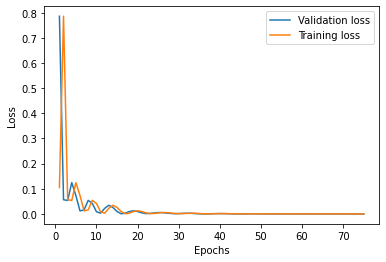

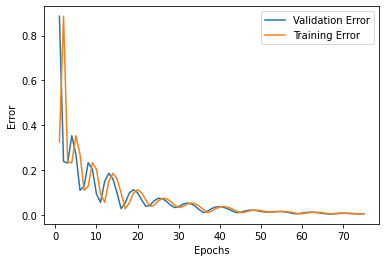

In [11]:
N=20
train_X,train_y = data_generator_pde(N)
model, weights = train_and_val(ann,nn.MSELoss,nn.MSELoss,train_X,train_X,75,N,lr=1e-3,early_stop=True,l2=False)

In [9]:
def error_analy(x,y):
    error = np.sum(np.true_divide(abs(x-y),y))*100/(len(y))
    return error

def evaluate_ind(model, inputs, outputs,error_fn,print_error=True):
        loss_fn = nn.MSELoss()
        inputs = torch.FloatTensor(inputs) 
        predictions = model.forward(inputs).squeeze(-1)
        print(predictions)
        print(outputs)
        error = error_fn(predictions.detach().numpy(),outputs)
        if print_error:
            print("Testing set Precentage Error: %.3f" % error)
        return error

In [10]:
test_y = data_generator(N,1)

evaluate_ind(model,train_X,test_y,error_analy)

tensor([ 7.9071e-03,  7.2247e-03,  6.5728e-03,  5.9541e-03,  5.3697e-03,
         4.8199e-03,  4.3034e-03,  3.8182e-03,  3.3616e-03,  2.9308e-03,
         2.5229e-03,  2.1353e-03,  1.7661e-03,  1.4143e-03,  1.0800e-03,
         7.6430e-04,  4.6987e-04,  2.0020e-04, -4.0427e-05, -2.4769e-04],
       grad_fn=<SqueezeBackward1>)
[0.18393972 0.20435757 0.22704186 0.25224418 0.28024402 0.31135193
 0.34591291 0.38431026 0.42696983 0.47436474 0.47436474 0.42696983
 0.38431026 0.34591291 0.31135193 0.28024402 0.25224418 0.22704186
 0.20435757 0.18393972]
Testing set Precentage Error: 98.858


98.85818344289994